In [1]:
import canny
import hough
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [13, 8]

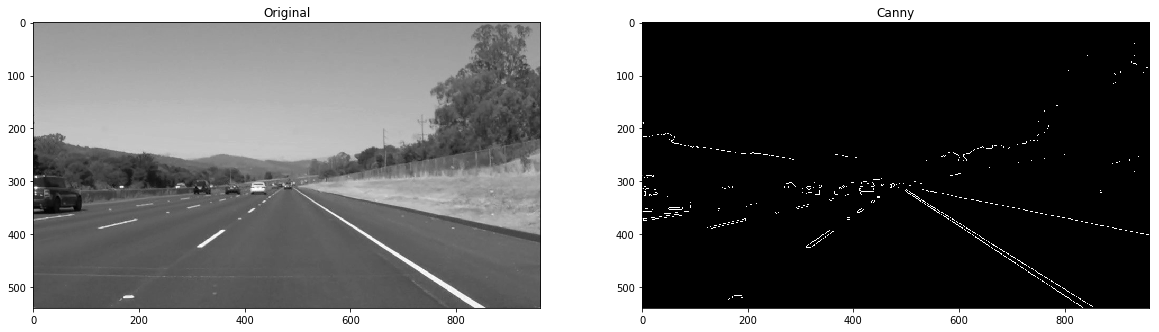

In [ ]:
img = cv2.imread('img/lane1.jpeg',0)
img_edges = canny.Canny(img)

fig = plt.figure(figsize=(20, 18))
a = fig.add_subplot(1,2,1)
plt.imshow(img,'gray')
a.set_title('Original')
a = fig.add_subplot(1,2,2)
plt.imshow(img_edges,'gray')
a.set_title('Canny')
plt.show()

In [ ]:
lines = hough.HoughLines(img_edges)

fig = plt.figure(figsize=(18, 18))
a = fig.add_subplot(1,2,1)
plt.imshow(lines[0])
a.set_title('Lines')
a = fig.add_subplot(1,2,2)
plt.imshow(lines[1],'gray')
a.set_title('Hough Space')
plt.show()